# Grazing Usecase Draft <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">
## Objectives: 
Create notebook with easily changable variables and support for arbitrary shapefiles that computes Vegetation Phenology statistics

Structure notebook so that outputs can be used to actively monitor the conservancy

## Purpose:
Increasing grazing efficiency and reduce conflicting grazing patterns with settlements in the Ruko Conservancy.
This notebook provides several examples of how to visualize captures from Sentinel2 and the derived phenology statistics.
EVI is used as the primary phenological indicator but other indices could be set (such as NDVI, LAI, etc).
The data is downsampled by default so that large areas maybe run on a default sandbox instance.


In [1]:
# %matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import sys, warnings

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry

sys.path.append('../Scripts')
sys.path.append('../DCAL/DCAL_utils')
from deafrica_datahandling import load_ard, wofs_fuser
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb, xr_animation
from deafrica_dask import create_local_dask_cluster
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb, map_shapefile
from deafrica_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
cluster = create_local_dask_cluster(n_workers=14, spare_mem= '2gb')

<Client: 'tcp://127.0.0.1:36571' processes=14 threads=14, memory=14.11 GB>

In [3]:
dc = datacube.Datacube(app='Grazing Analysis')

In [4]:
time_range = ('2013', '2021')

products = ['s2_l2a']

bands = ['red',
         'green',
         'blue',
         'nir',
         'swir_1']

resolution = (-30,30)

#align = (15, 15)

query = {'time': time_range,
         'products': products,
         'measurements': bands,
         'resolution': resolution,
         'output_crs': 'EPSG:6933',
         #align': align,
         'min_gooddata': 0
         }


attribute_col = 'id'

<div class="alert alert-block alert-info"><b>Shapefile Input:</b> Change the shapefile specified as the "vector_file" variable below to change areas. Make sure the shapefile is uploaded to the same directory and spelled correctly.</div>

In [5]:
vector_file = 'Ruko_Conservancy.shp'

In [6]:
#read shapefile
gdf = gpd.read_file(vector_file)

# add an ID column
gdf['id']=range(0, len(gdf))

#print gdf
gdf.head()

geometry  id
0  POLYGON ((180489.405 63848.881, 180448.606 638...   0

In [7]:
from typing import NamedTuple

class Location(NamedTuple):
    name: str
    lat: float
    lon: float
    area: float = .20
        
ruko = Location(
    name = 'Ruko Conservancy',
    lat = .6619,
    lon = 36.1141
)

In [8]:
def create_extent(location):
    #transforms a location into area for loading
    buffer= location.area/2
    lat_range = (location.lat-buffer, location.lat+buffer)
    lon_range = (location.lon-buffer, location.lon+buffer)
    extent = { 'y': lat_range, 'x': lon_range}
    return extent

In [9]:
extent = create_extent(ruko)

In [10]:
gdf.set_crs(crs='EPSG:32637',inplace=True, allow_override=True )

geometry  id
0  POLYGON ((180489.405 63848.881, 180448.606 638...   0

In [11]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(center=[0.648084104061088, 36.12258148195494], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [12]:
gdf.crs.to_epsg()

32637

In [13]:
geom = geometry.Geometry(gdf.iloc[0].geometry.__geo_interface__,
                         geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    
ds = load_ard(dc=dc,
              group_by='solar_day',
              dask_chunks={},
              #progress_cbk=with_ui_cbk(),
              geopolygon= geom,
              **query)

mask = xr_rasterize(gdf,ds)

ds_masked = ds.where(mask)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 275 time steps as a dask array
Rasterizing to match xarray.DataArray dimensions (796, 405)


In [14]:
ds

<xarray.Dataset>
Dimensions:      (time: 275, x: 405, y: 796)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2021-03-12T08:...
  * y            (y) float64 9.460e+04 9.458e+04 ... 7.078e+04 7.076e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 796, 405), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 796, 405), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 796, 405), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 796, 405), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 796, 405), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

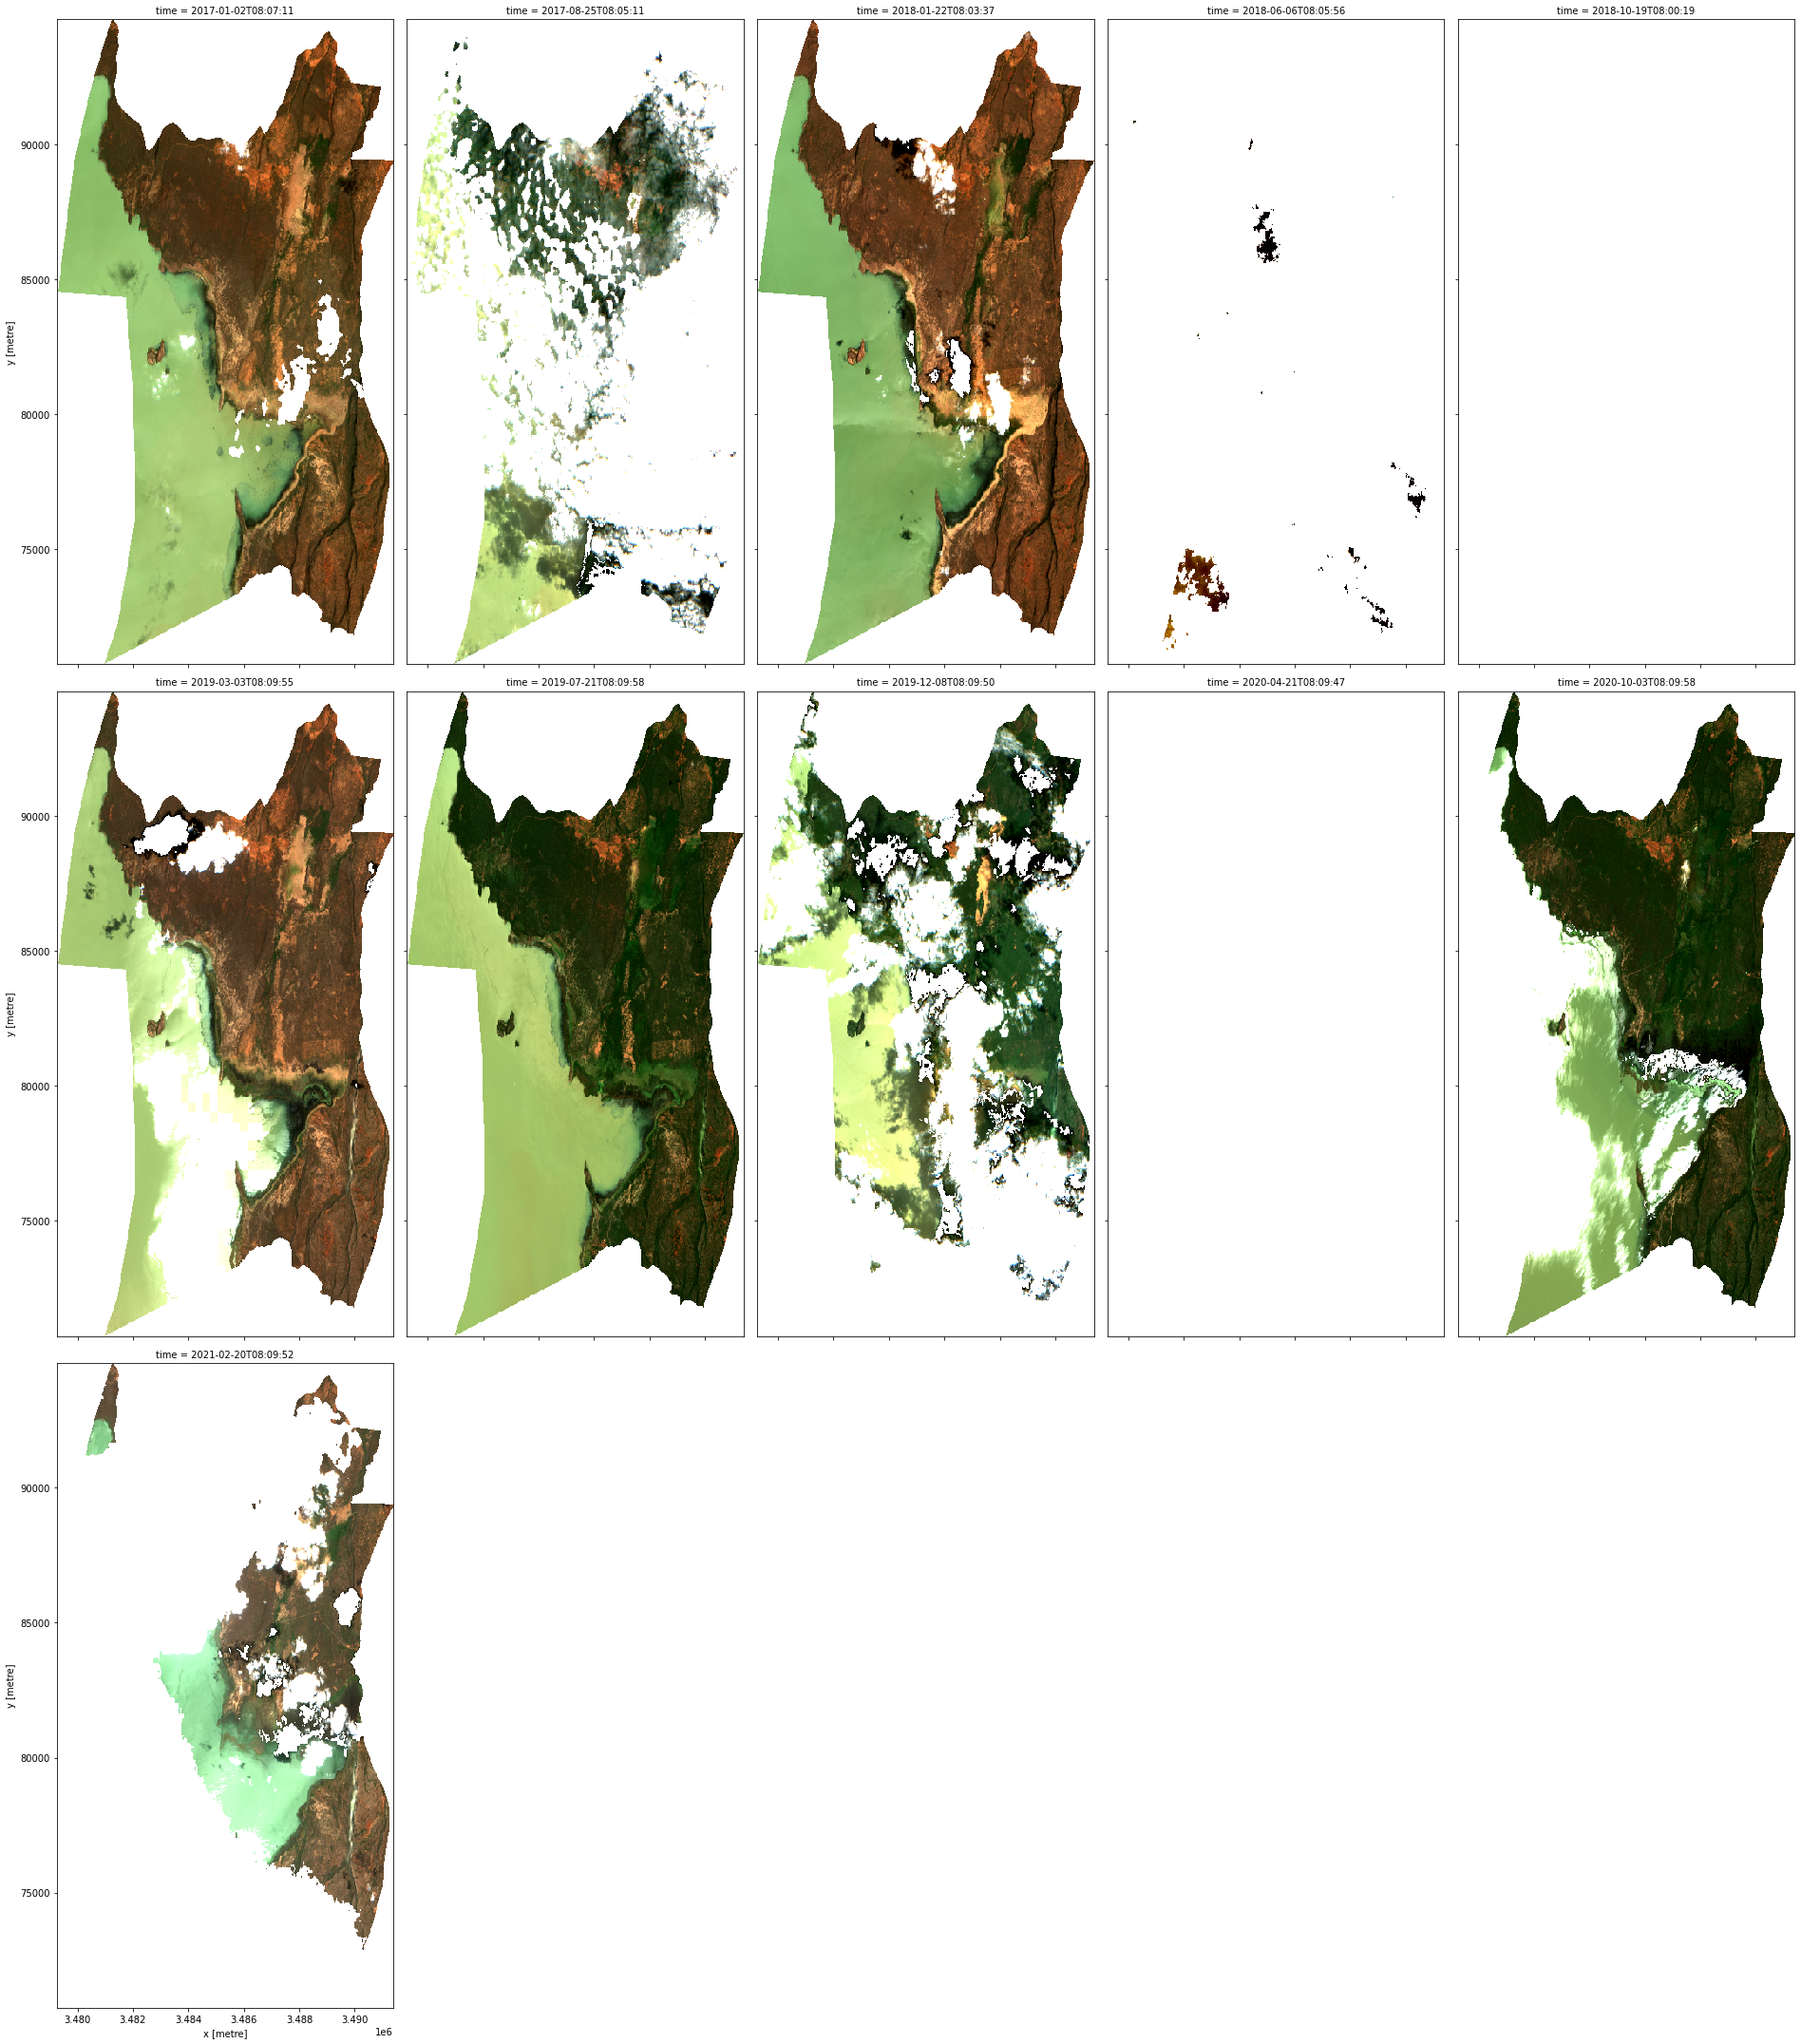

In [32]:
rgb(ds_masked, index=list(range(0,272,27)), col_wrap=5, size=10 )

In [16]:
indices = calculate_indices(ds=ds, index = ['MNDWI','EVI'], collection='s2')

In [17]:
def sample_xr(xarray,var=None):        
    xarray[var].isel(time = range(0,xarray.dims['time'], -(xarray.dims['time']//-10))).plot(col='time', col_wrap=5,cmap='viridis',robust=True)

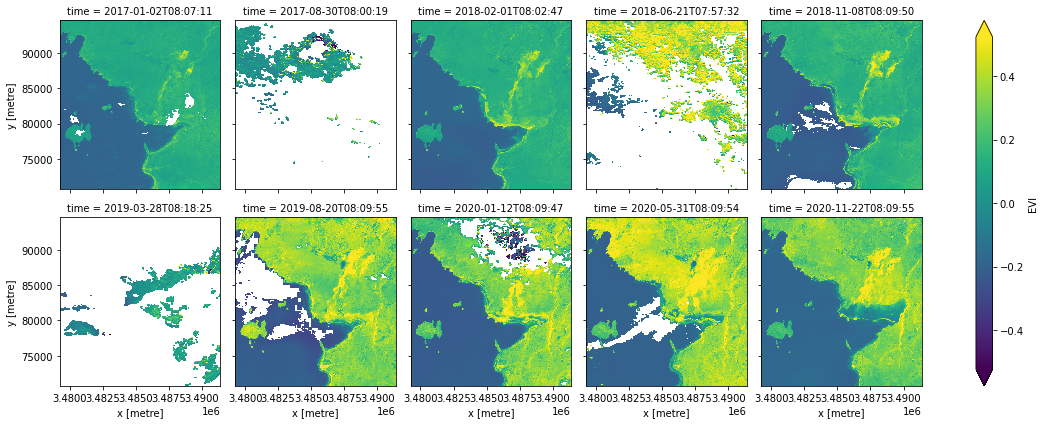

In [18]:
sample_xr(indices,'EVI')

In [19]:
indices['EVI_median'] = indices.EVI.groupby('time.month').median()
indices['MNDWI_median'] = indices.MNDWI.groupby('time.month').median()

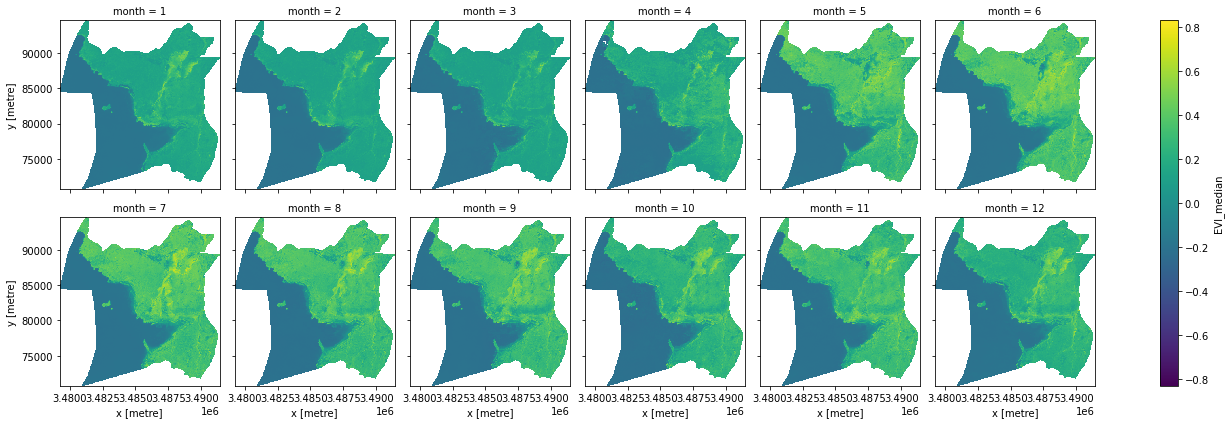

In [20]:
indices['EVI_median'] = indices.EVI.groupby('time.month').median()
indices.EVI_median.where(mask).plot(col='month', col_wrap=6,cmap='viridis')

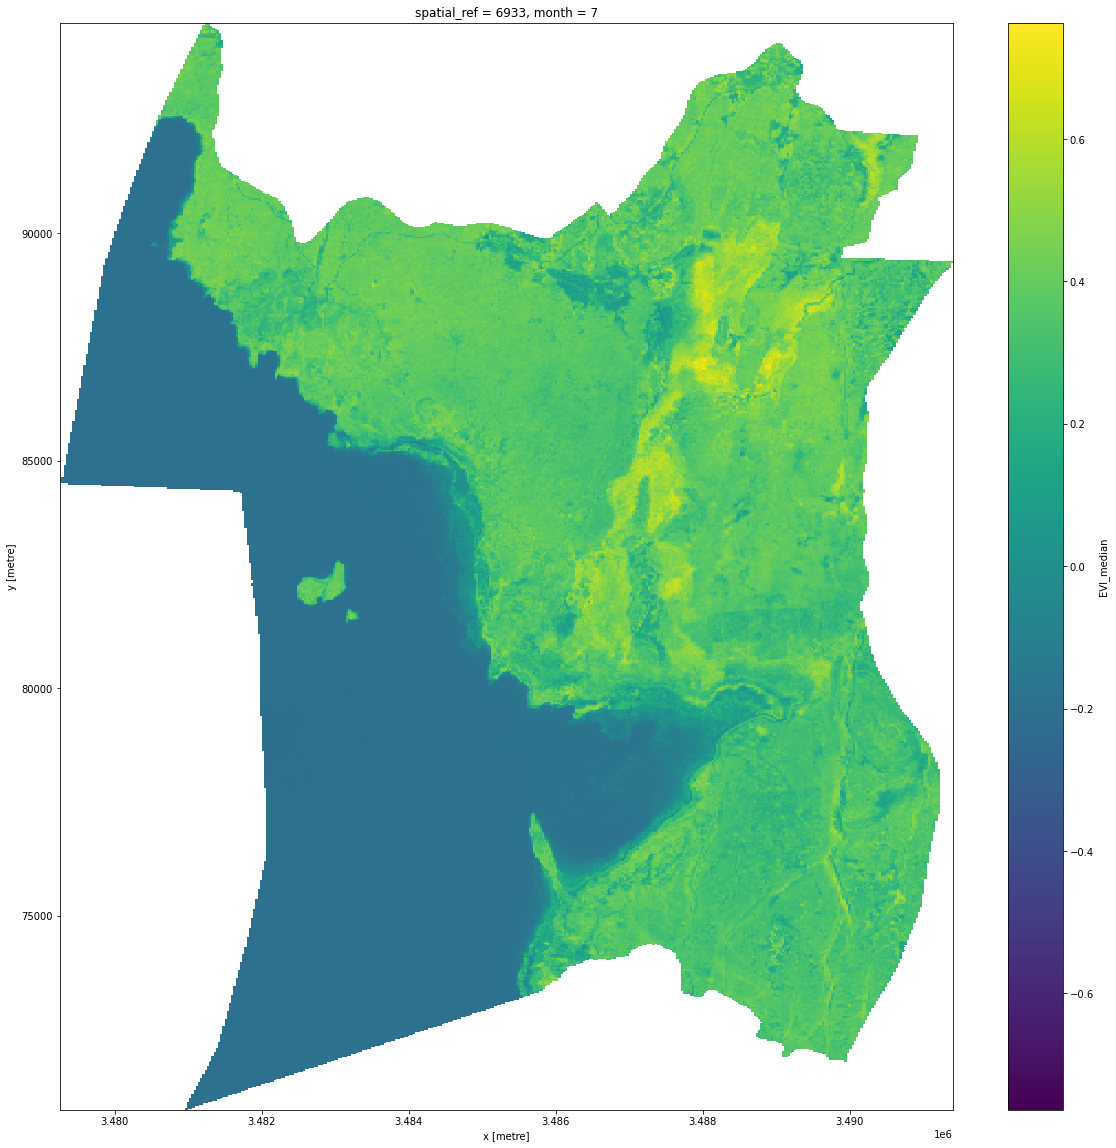

In [21]:
indices.EVI_median.where(mask).isel(month =6).plot(figsize = (20,20), cmap='viridis')

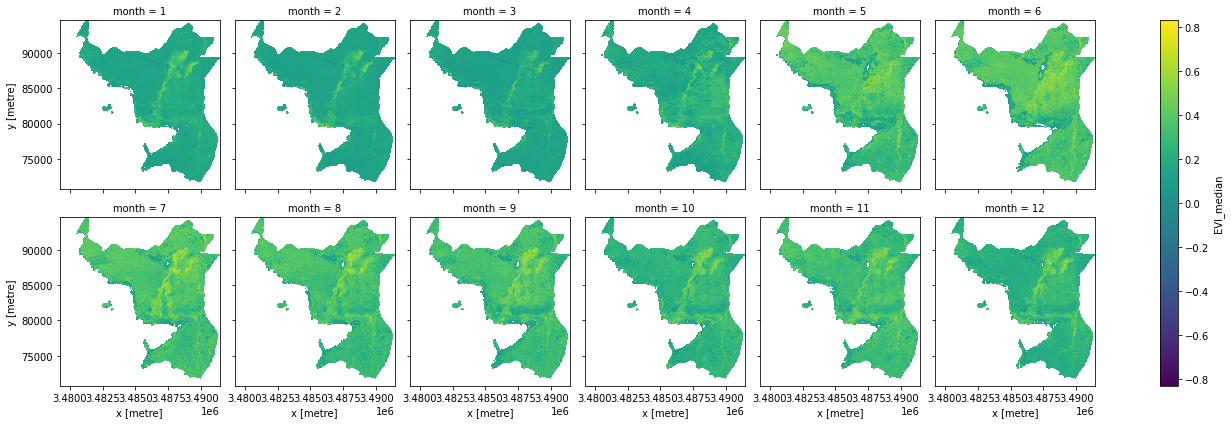

In [22]:
indices.EVI_median.where(mask).where(indices.MNDWI_median<0).plot(col='month', col_wrap=6,cmap='viridis')

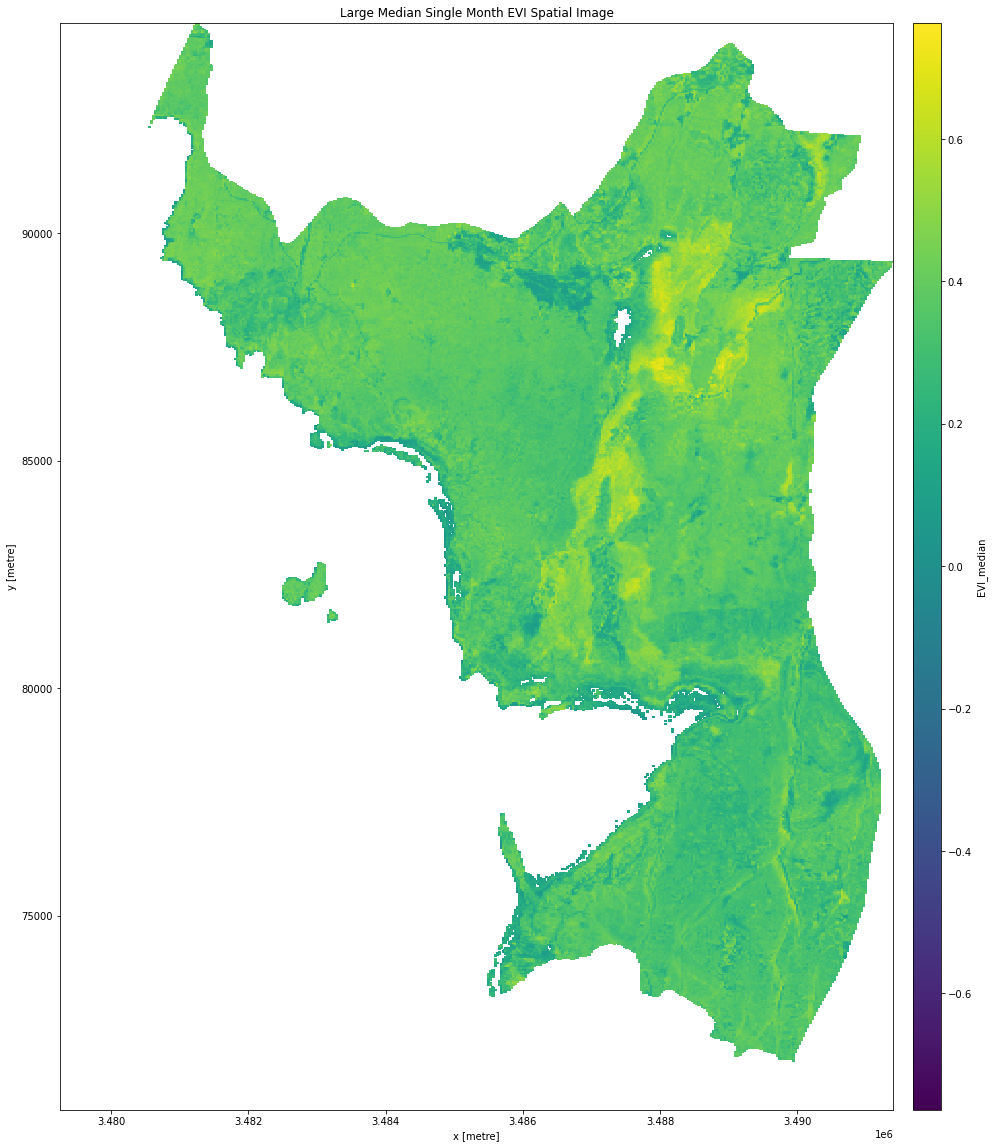

In [23]:
indices.EVI_median.where(mask).where(indices.MNDWI_median<0).isel(month =6).plot(figsize = (18,20), cmap='viridis', cbar_kwargs={"aspect": 40, "pad": 0.02})
plt.title('Large Median Single Month EVI Spatial Image');

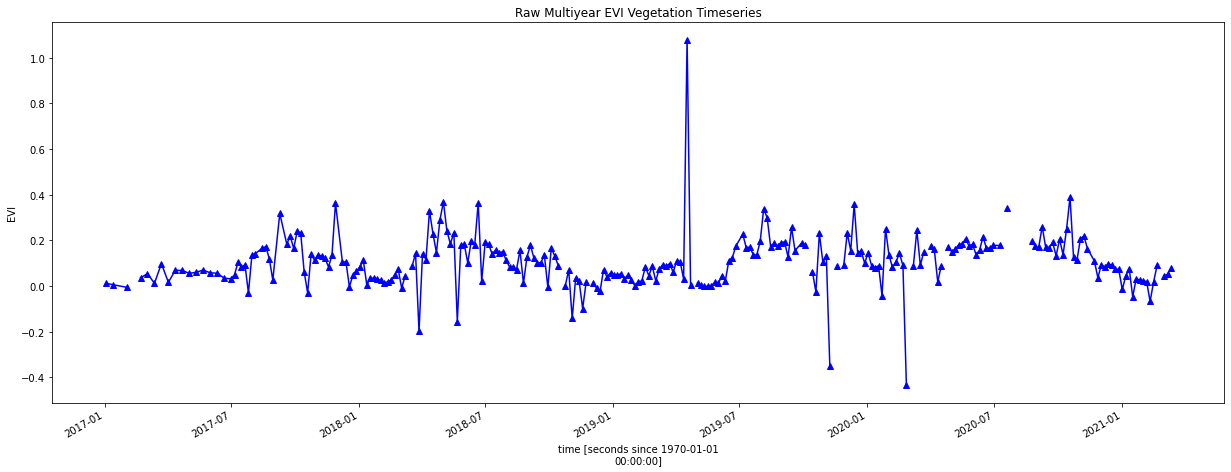

In [24]:
indices.EVI.mean(['x', 'y']).plot.line('b-^', figsize=(21,7))
plt.title('Raw Multiyear EVI Vegetation Timeseries');

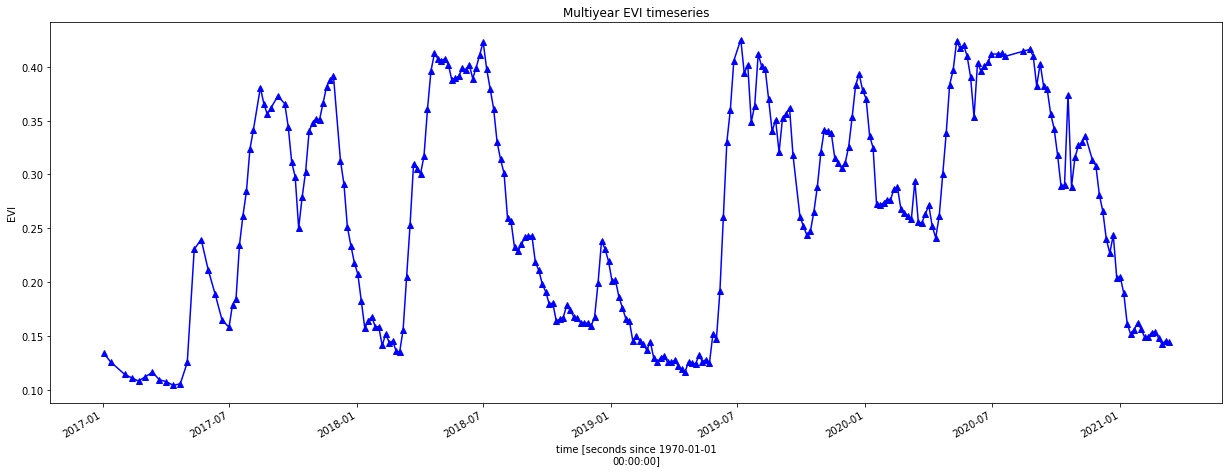

In [25]:
indices.EVI.where(mask).where(indices.MNDWI<0).compute().interpolate_na(dim='time', method='linear').mean(['x', 'y']).plot.line('b-^', figsize=(21,7))
plt.title('Multiyear EVI timeseries');

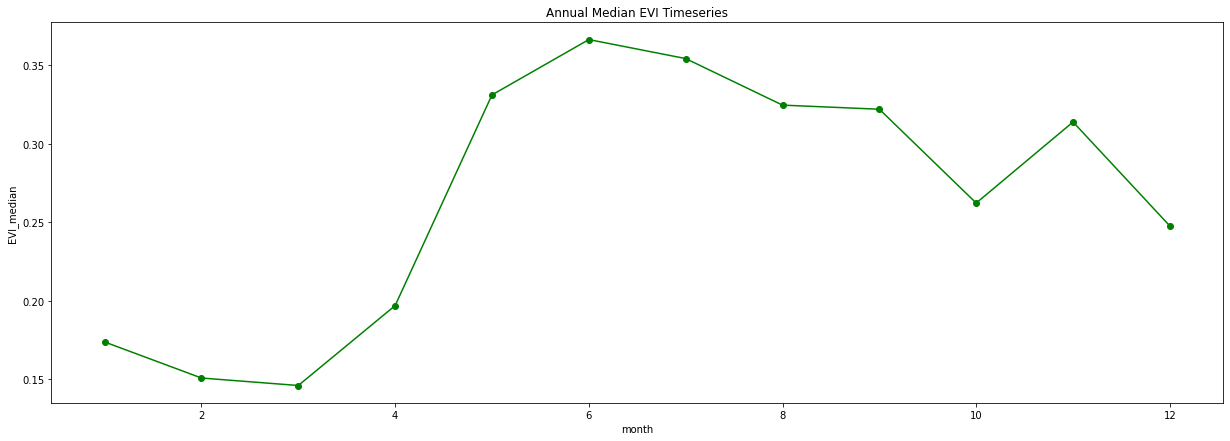

In [26]:
indices.EVI_median.where(mask).where(indices.MNDWI_median<0).mean(['x', 'y']).plot.line('g-o', figsize=(21,7))
plt.title('Annual Mean EVI Timeseries');

In [27]:
evi = indices.EVI.where(mask).where(indices.MNDWI<0).compute().interpolate_na(dim='time', method='linear').mean(['x', 'y'])

In [28]:
evi_years = evi.groupby('time.year')

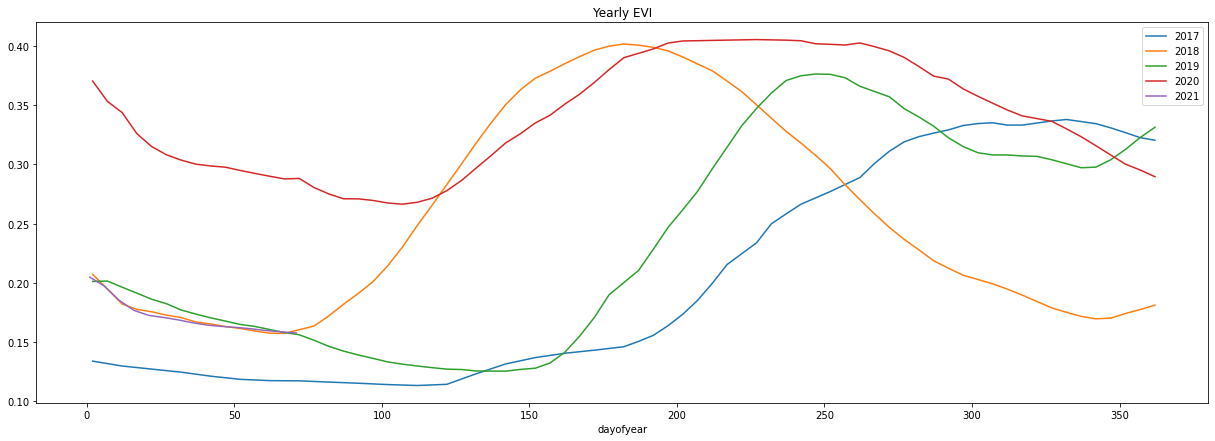

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(21,7)
for year in evi_years:
    year[1].groupby('time.dayofyear').mean().rolling(dayofyear=15, min_periods=1).mean().plot(ax=ax, label=year[0])
ax.legend()
plt.title('Yearly EVI');

<div class="alert alert-block alert-info"><b>Yearly Statistics Input:</b> Please specify the desired year for phenological statistics using the "year" variable below.

In [30]:
year= 2018
year_ds = dict(evi_years)[year]

In [31]:
import deafrica_temporal_statistics as ts
import datetime

phen = ts.xr_phenology(
        year_ds,
        method_sos='median',
        method_eos='median',
        complete='none',
        smoothing='rolling_mean',
    ).compute()

print(phen)

for stat in phen:
    if stat in ['SOS','POS','EOS']:
        value = phen[stat].values
        print(stat + ' ' + datetime.datetime.strptime(f'{year} {phen[stat].values}', '%Y %j').strftime('%m/%d/%Y'))
    


   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS
<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 6933
Data variables:
    SOS          int16 87
    POS          int16 182
    EOS          int16 267
    Trough       float32 0.13868675
    vSOS         float32 0.28933498
    vPOS         float32 0.41103706
    vEOS         float32 0.20895515
    LOS          int16 180
    AOS          float32 0.2723503
    ROG          float32 0.0012810745
    ROS          float32 -0.0023774342
SOS 03/28/2018
POS 07/01/2018
EOS 09/24/2018


<div class="alert alert-block alert-info"><b>Gener:</b> Please specify the desired year for phenological statistics using the "year" variable below.

In [31]:
import deafrica_temporal_statistics as ts
import datetime

phen = ts.xr_phenology(
        year_ds,
        method_sos='median',
        method_eos='median',
        complete='none',
        smoothing='rolling_mean',
    ).compute()

print(phen)

for stat in phen:
    if stat in ['SOS','POS','EOS']:
        value = phen[stat].values
        print(stat + ' ' + datetime.datetime.strptime(f'{year} {phen[stat].values}', '%Y %j').strftime('%m/%d/%Y'))
    


   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS
<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 6933
Data variables:
    SOS          int16 87
    POS          int16 182
    EOS          int16 267
    Trough       float32 0.13868675
    vSOS         float32 0.28933498
    vPOS         float32 0.41103706
    vEOS         float32 0.20895515
    LOS          int16 180
    AOS          float32 0.2723503
    ROG          float32 0.0012810745
    ROS          float32 -0.0023774342
SOS 03/28/2018
POS 07/01/2018
EOS 09/24/2018


In [52]:
phen.expand_dims({'year':[year]}).to_dataframe().to_csv(f'./{year}_phenology_stats.csv')

In [31]:
import deafrica_temporal_statistics as ts
import datetime

for year in evi_years:
    phen = ts.xr_phenology(
            dict(evi_years)[year],
            method_sos='median',
            method_eos='median',
            complete='none',
            smoothing='rolling_mean',
        ).compute()

    print(phen)

    for stat in phen:
        if stat in ['SOS','POS','EOS']:
            value = phen[stat].values
            print(stat + ' ' + datetime.datetime.strptime(f'{year} {phen[stat].values}', '%Y %j').strftime('%m/%d/%Y'))



   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS
<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 6933
Data variables:
    SOS          int16 87
    POS          int16 182
    EOS          int16 267
    Trough       float32 0.13868675
    vSOS         float32 0.28933498
    vPOS         float32 0.41103706
    vEOS         float32 0.20895515
    LOS          int16 180
    AOS          float32 0.2723503
    ROG          float32 0.0012810745
    ROS          float32 -0.0023774342
SOS 03/28/2018
POS 07/01/2018
EOS 09/24/2018


In [50]:
phen_experiment = phen.expand_dims({'stats': ['SOS','POS','EOS','Trough','vSOS','vPOS','vEOS','LOS','AOS','ROG','ROS'], 'year': [year]})


In [51]:
phen_experiment

<xarray.Dataset>
Dimensions:      (stats: 11, year: 1)
Coordinates:
  * stats        (stats) <U6 'SOS' 'POS' 'EOS' 'Trough' ... 'AOS' 'ROG' 'ROS'
  * year         (year) int64 2018
    spatial_ref  int32 6933
Data variables:
    SOS          (stats, year) int16 87 87 87 87 87 87 87 87 87 87 87
    POS          (stats, year) int16 182 182 182 182 182 182 182 182 182 182 182
    EOS          (stats, year) int16 267 267 267 267 267 267 267 267 267 267 267
    Trough       (stats, year) float32 0.13868675 0.13868675 ... 0.13868675
    vSOS         (stats, year) float32 0.28933498 0.28933498 ... 0.28933498
    vPOS         (stats, year) float32 0.41103706 0.41103706 ... 0.41103706
    vEOS         (stats, year) float32 0.20895515 0.20895515 ... 0.20895515
    LOS          (stats, year) int16 180 180 180 180 180 180 180 180 180 180 180
    AOS          (stats, year) float32 0.2723503 0.2723503 ... 0.2723503
    ROG          (stats, year) float32 0.0012810745 ... 0.0012810745
    ROS          (stats, year) float32 -0.0023774342 ... -0.0023774342